In this notebook we show manual annotations done by pathologists as a QC step. We show spatially preserved regions (shown in red) and tissue areas with poor cytomorphological preservation (shown in blue)

In [1]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#
import spatialdata
import spatialdata_plot

import sys
sys.path.append('..')
from configuration import STConfig
from wrappers.sdata_initalizer import SDataInitalizer
from wrappers.sdata_customizer import SDataCustomizer

In [2]:
cfg = STConfig()
meta_df = pd.read_csv(cfg.pth_meta_csv)
samples = meta_df['sample_key'].tolist()
print(f'Number of samples {len(samples)}')
print(samples)

Number of samples 32
['10693_R2', '10693_R1', '16832_R1', '16832_R2', '16818_R2', '16818_R1', '16818_R3', '18552_R3', '18552_R1', '18552_R2', '18550_R1', '18550_R3', '18550_R2', '18606_R2', '18606_R3', '18606_R1', '18599_R3', '18599_R1', '18599_R2', '18286_R3', '18286_R2', '18286_R1', '18256_R3', '18256_R1', '18256_R2', '18612_R1', '18612_R4', '18612_R2', '18612_R3', '18669_R3', '18669_R2', '18669_R1']


0it [00:00, ?it/s]

Visualizing Manual Annotation for sample 16818_R1


1it [02:38, 158.20s/it]

Visualizing Manual Annotation for sample 18669_R3


2it [06:38, 206.60s/it]

Visualizing Manual Annotation for sample 18669_R3


3it [10:28, 217.39s/it]

Visualizing Manual Annotation for sample 18669_R1


4it [13:07, 196.78s/it]


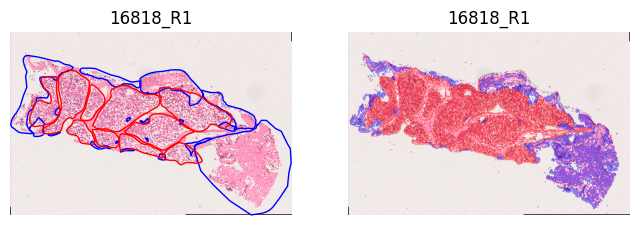

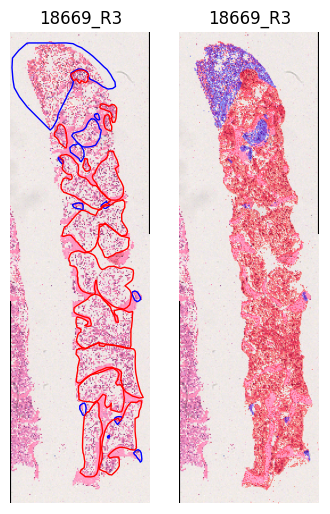

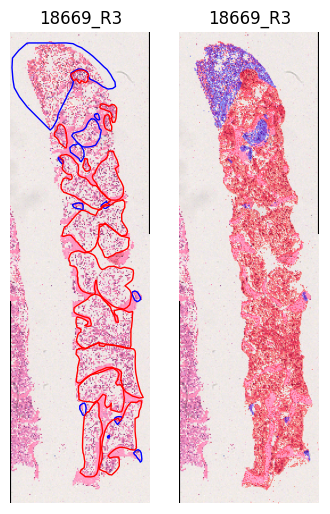

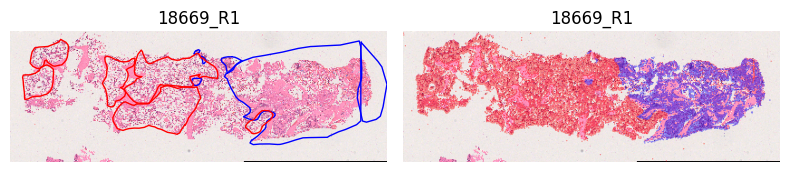

In [10]:
# To make notebook size managable we show only 3 random samples
N_samples = 3
samples = np.array(samples)
samples = list(samples[np.random.randint(0, len(samples), N_samples)]) + ['18669_R1']

for idx, sample_id in tqdm(enumerate(samples)):
    print(f'Visualizing Manual Annotation for sample {sample_id}')
    customizer = SDataCustomizer(config=cfg, sample_key=sample_id)
    sdata_file_path = f'{cfg.pth_sdata}/{sample_id}_no_he.zarr'
    sdata_obj = spatialdata.read_zarr(sdata_file_path)

    # getting WSI x,y bounds
    gdf = pd.concat(
        [sdata_obj.shapes['new_cell_boundaries'].geometry, sdata_obj.shapes['crushed_regions'].geometry],
        ignore_index=True
        )

    minx, miny, maxx, maxy = gdf.total_bounds
    sdata_obj_roi = sdata_obj.query.bounding_box(
        axes=["x", "y"],
        min_coordinate=[minx, miny],
        max_coordinate=[maxx, maxy],
        target_coordinate_system="global",
    )

    width  = maxx - minx
    height = maxy - miny

    if width > height:
        # Tissue section oriented horizontally
        figsize = (8, 4)
    else:
        figsize = (4, 8)      
    
    # Visualizing manual annotations polygon
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    axes = axes.flatten()
    ax_0 = axes[0]
    sdata_obj_roi.pl.render_images(customizer.he_key).pl.show("global", title="", ax=ax_0)
    sdata_obj_roi["crushed_regions"].plot(ax=ax_0, facecolor="none", edgecolor="blue", alpha=1, linewidth=1)
    sdata_obj_roi["intertrabecular_regions"].plot(ax=ax_0, facecolor="none", edgecolor="red", alpha=1, linewidth=1)
    ax_0.axis("off")
    ax_0.set_title(sample_id)

    # Coloring cells that are spatially unpreserved vs preserved. 
    ax_1 = axes[1]
    sdata_obj_roi.pl.render_images(customizer.he_key).pl.show("global", title="", ax=ax_1)
    spat_unpreserved = sdata_obj.tables['table'].obs['annotation'] == 'remove'
    sdata_obj_roi["new_cell_boundaries"][spat_unpreserved].plot(
        ax=ax_1, facecolor="blue", edgecolor="none", alpha=0.5, linewidth=1
    )
    sdata_obj_roi["new_cell_boundaries"][~spat_unpreserved].plot(
        ax=ax_1, facecolor="red", edgecolor="none", alpha=0.5, linewidth=1
    )

    ax_1.axis("off")
    ax_1.set_title(sample_id)

plt.tight_layout()
plt.show()
